In [1]:

import math, json, os
from pathlib import Path
import numpy as np
import torch
import matplotlib.pyplot as plt

# matplotlib defaults
plt.rcParams['figure.dpi'] = 140
plt.rcParams['savefig.bbox'] = 'tight'

DEVICE = 'cpu'
torch.set_default_dtype(torch.float32)



In [2]:
import sys
sys.path.append('../..')
from experiments_refactored.datasets.position_dependent_gaussian import GaussianFieldGenerator
from experiments_refactored.datasets.config import FIELD_CONFIG

# Use default 2000/200/200 from config but with enhanced exploration
CONFIG = FIELD_CONFIG.copy()


In [3]:
gen = GaussianFieldGenerator("data/clean_viz", CONFIG)  
datasets = gen.generate_datasets()

# Extract data
coords_train = datasets['train']['sparse']['coordinates']  # [2000, 20, 2]
frames_train_sparse = datasets['train']['sparse']['frames']
frames_train_gauss = datasets['train']['gaussian']['frames']

Generating datasets with mode: center_inward
Training size: 2000, Validation size: 200, Test size: 200
Generating training dataset...
Generating validation dataset...
Generating test dataset...
Saving datasets...
All datasets saved to data/clean_viz


In [4]:
frames_train_gauss.shape


torch.Size([2000, 20, 1, 32, 32])

In [5]:
def plot_single_trajectory(coords, seq_idx, subplot_pos=None):
    """Plot one clean trajectory."""
    if subplot_pos is None:
        plt.figure(figsize=(5,5))
        ax = plt.gca()
    else:
        ax = plt.subplot(*subplot_pos)
    
    y = coords[seq_idx,:,0].numpy()
    x = coords[seq_idx,:,1].numpy()
    
    # Simple trajectory line
    ax.plot(x, y, '-', color='blue', lw=2, alpha=0.8)
    ax.plot(x, y, 'o', color='blue', ms=3, alpha=0.6)
    
    # Mark start and end only
    ax.plot(x[0], y[0], 's', color='green', markersize=8, label='Start (0,0)')
    ax.plot(x[-1], y[-1], '^', color='red', markersize=8, label='End')
    
    ax.invert_yaxis()
    ax.set_xlim(-2, 34); ax.set_ylim(34, -2)
    ax.grid(True, alpha=0.3)
    ax.set_title(f' Sample {seq_idx}')
    ax.set_xlabel('x'); ax.set_ylabel('y')
    if seq_idx == 0: ax.legend()
    
    if subplot_pos is None:
        plt.show()


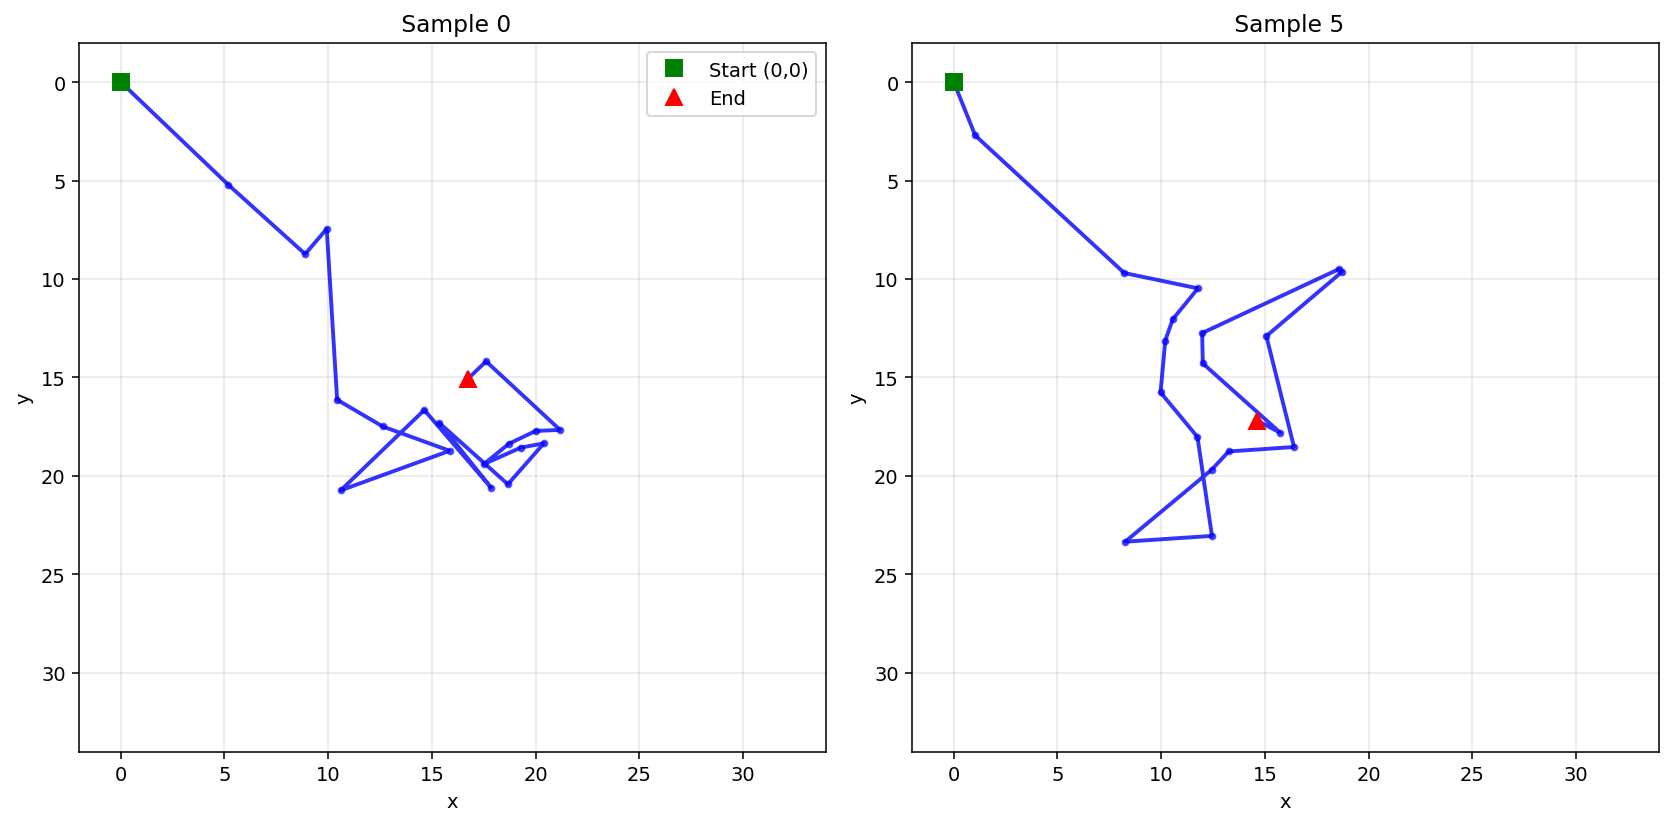

In [26]:
plt.figure(figsize=(18, 6))
plot_single_trajectory(coords_train, 0, (1, 3, 1))
plot_single_trajectory(coords_train, 5, (1, 3, 2))
# plot_single_trajectory(coords_train, 12, (1, 3, 3))
plt.tight_layout()
plt.show()

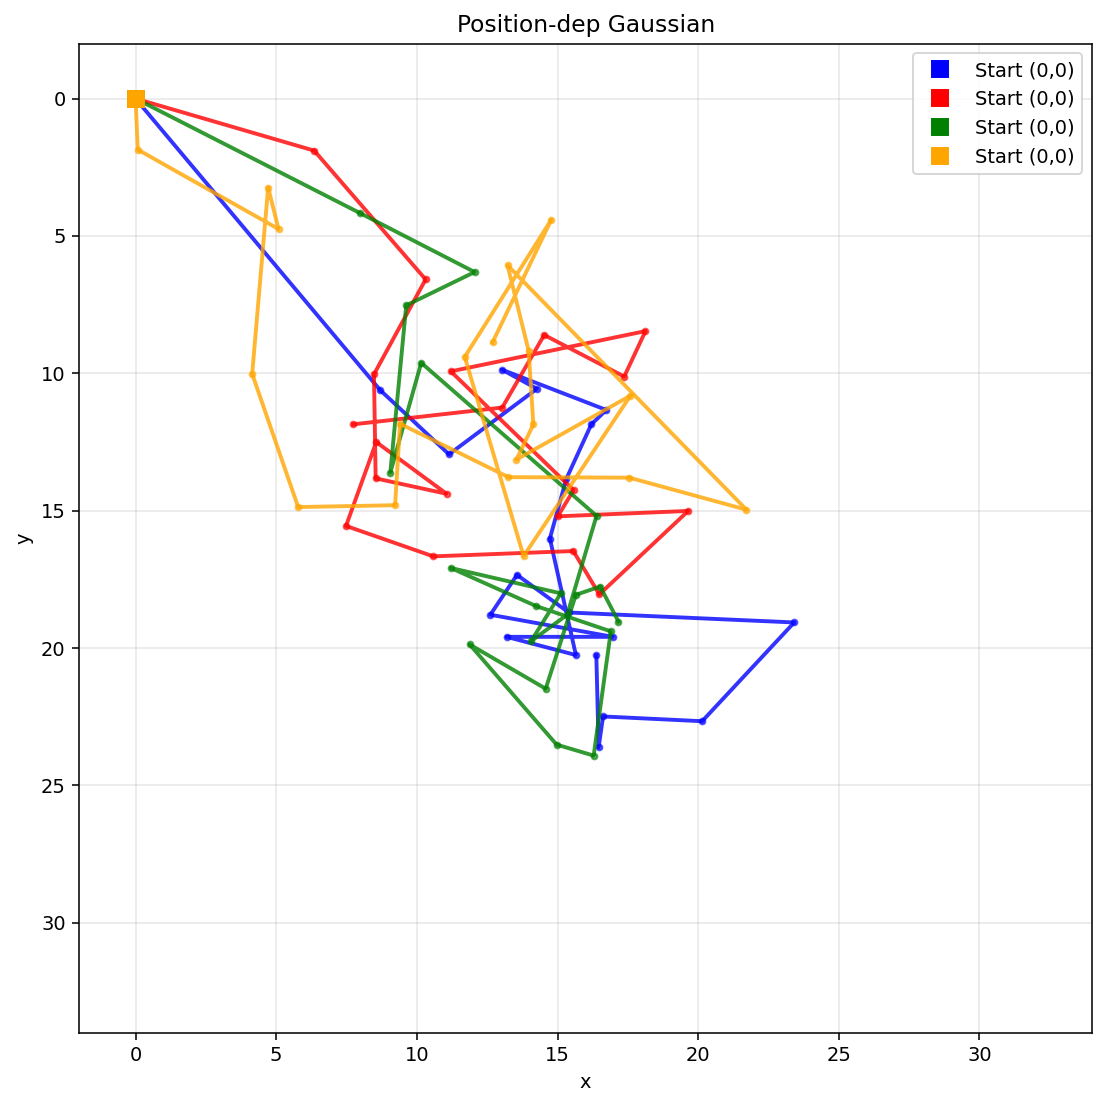

In [19]:
def plot_multi_trajectories(coords, seq_idxs, colors=['blue', 'red', 'green','yellow'], subplot_pos=None):
    """Plot multiple clean trajectories."""
    if subplot_pos is None:
        plt.figure(figsize=(8,8))
        ax = plt.gca()
    else:
        ax = plt.subplot(*subplot_pos)

    for seq_idx in seq_idxs:
        y = coords[seq_idx,:,0].numpy()
        x = coords[seq_idx,:,1].numpy()
        
        ax.plot(x, y, '-', color=colors[seq_idx-10], lw=2, alpha=0.8)
        ax.plot(x, y, 'o', color=colors[seq_idx-10], ms=3, alpha=0.6)

        ax.plot(x[0], y[0], 's', color=colors[seq_idx-10], markersize=8, label='Start (0,0)')

    ax.grid(True, alpha=0.3)
    ax.legend()
    ax.invert_yaxis()
    ax.set_xlim(-2, 34); ax.set_ylim(34, -2)
    ax.set_title(f'Position-dep Gaussian')
    ax.set_xlabel('x'); ax.set_ylabel('y')
    
    plt.tight_layout()
    plt.show()

plot_multi_trajectories(coords_train, [10,11,12,13], colors=['blue', 'red', 'green','orange'])

            
        

Upper Edge → DOWN - Position (y=0, x=16):
  Direction to center: dy=16, dx=0
  Computed mu: [0.849, 0.000] (dy, dx)
  Sigma diagonal: [0.447, 0.203]


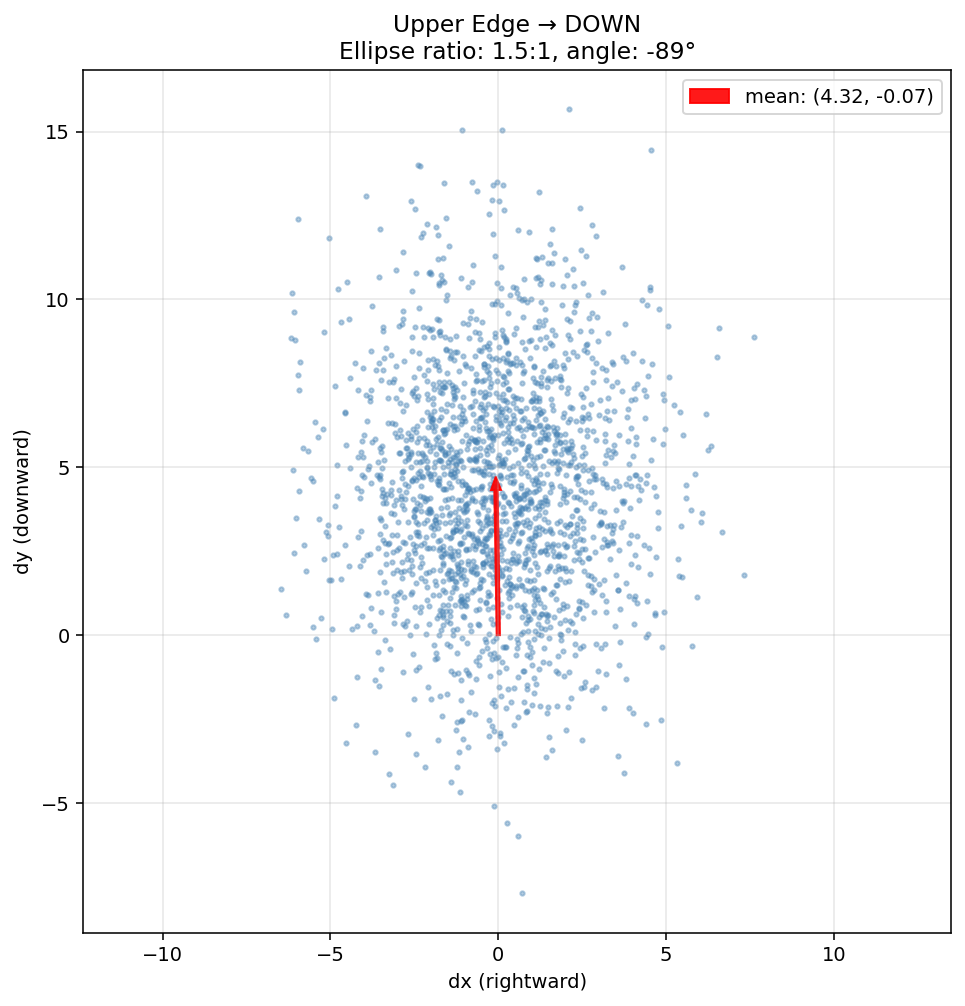

  ratio: 1.5:1
Left Edge → RIGHT - Position (y=5, x=20):
  Direction to center: dy=11, dx=-4
  Computed mu: [0.583, -0.212] (dy, dx)
  Sigma diagonal: [0.368, 0.282]


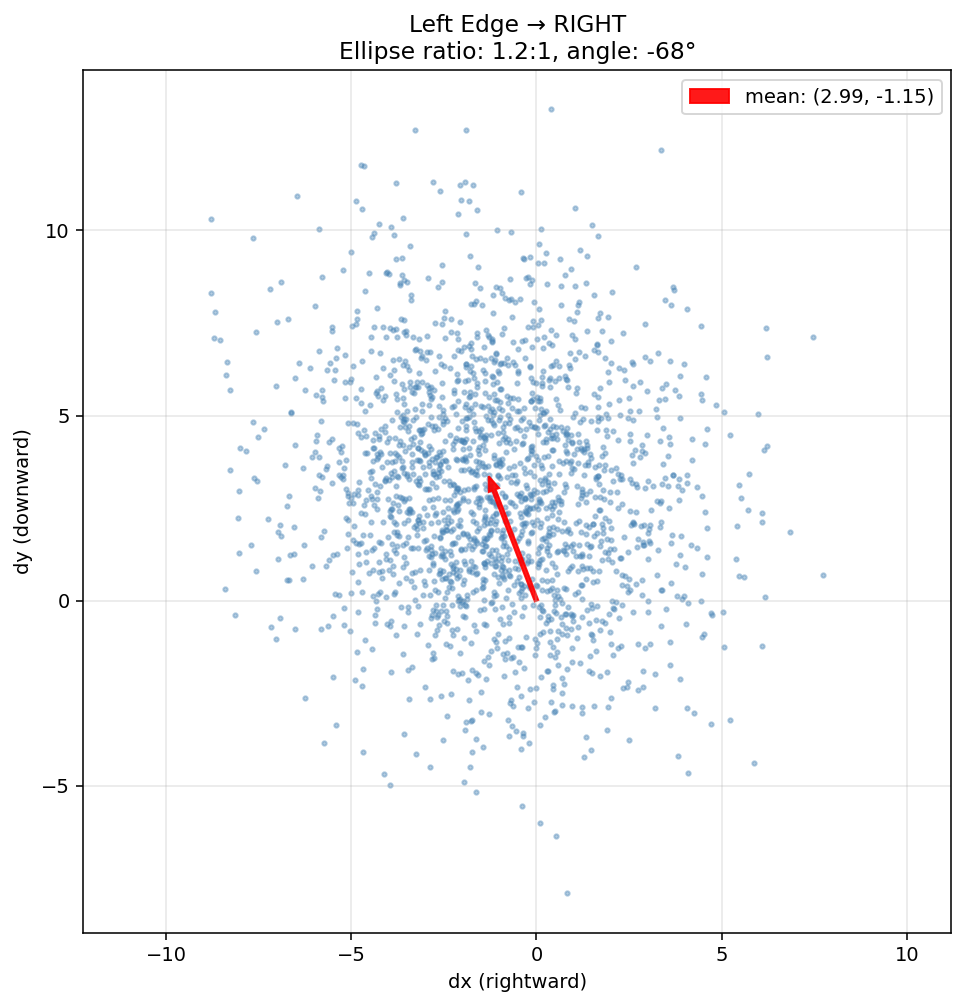

  ratio: 1.2:1
Corner → DIAGONAL - Position (y=0, x=0):
  Direction to center: dy=16, dx=16
  Computed mu: [0.849, 0.849] (dy, dx)
  Sigma diagonal: [0.325, 0.325]


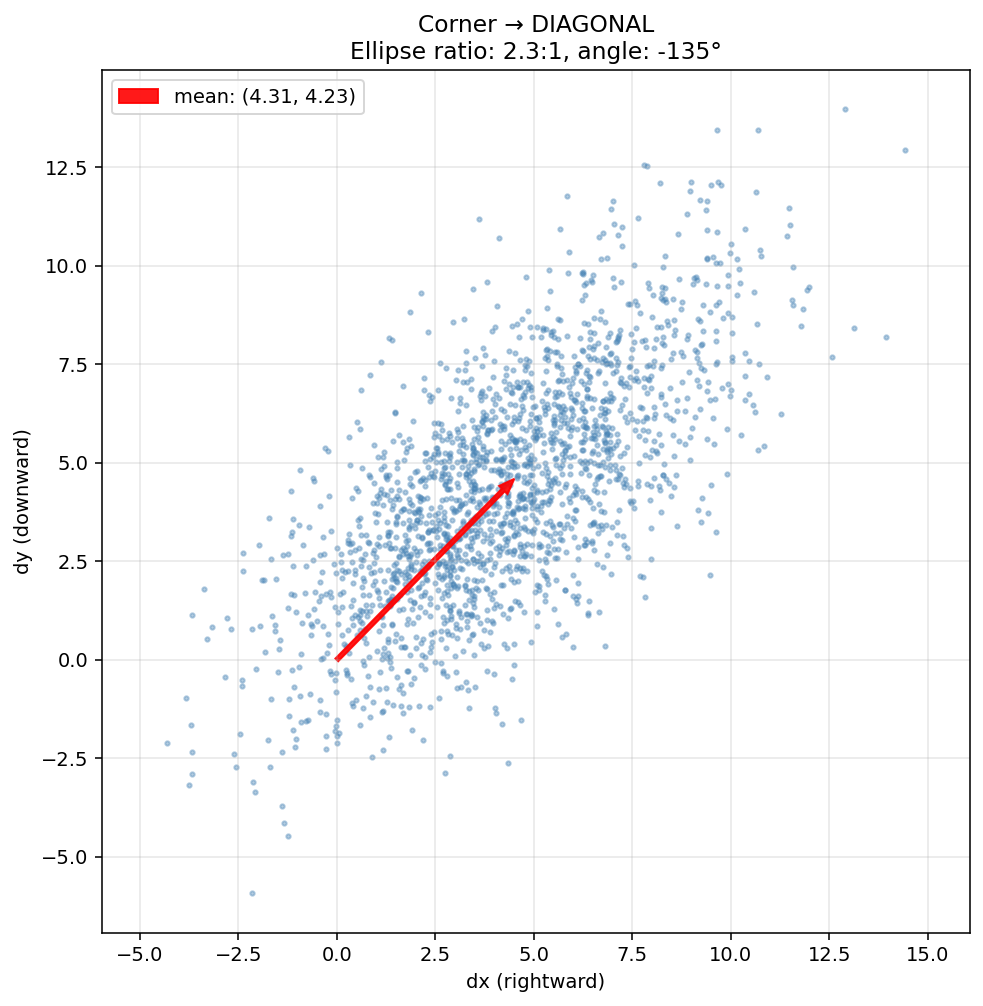

  ratio: 2.3:1


np.float64(2.314505246958103)

In [7]:
# Cell: Final Ellipse Verification (After Safety Patches)

import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import sys
sys.path.append('../..')
from experiments_refactored.datasets.position_dependent_gaussian import _compute_mu_sigma

def verify_corrected_ellipses(y, x, title, N=2000):
    """Verify ellipse orientation with outer product covariance."""
    mu, sigma = _compute_mu_sigma(y, x, 32, CONFIG)
    step_scale = CONFIG['step_scale']
    
    print(f"{title} - Position (y={y}, x={x}):")
    print(f"  Direction to center: dy={16-y}, dx={16-x}")
    print(f"  Computed mu: [{mu[0]:.3f}, {mu[1]:.3f}] (dy, dx)")
    print(f"  Sigma diagonal: [{sigma[0,0]:.3f}, {sigma[1,1]:.3f}]")
    
    # Sample with corrected covariance
    torch.manual_seed(200)
    samples = []
    for _ in range(N):
        cov_stable = sigma * step_scale**2 + 1e-6 * torch.eye(2)
        L = torch.linalg.cholesky(cov_stable)
        z = torch.randn(2)
        displacement = mu * step_scale + L @ z
        samples.append(displacement.numpy())
    
    samples = np.array(samples)
    dy_samples = samples[:, 0]  # y displacement
    dx_samples = samples[:, 1]  # x displacement
    
    plt.figure(figsize=(8, 8))
    plt.scatter(dx_samples, dy_samples, alpha=0.4, s=5, color='steelblue')
    
    # Empirical mean arrow
    mean_dx, mean_dy = dx_samples.mean(), dy_samples.mean()
    plt.arrow(0, 0, mean_dx, mean_dy, head_width=0.3, head_length=0.4,
              fc='red', ec='red', width=0.1, alpha=0.9,
              label=f'mean: ({mean_dy:.2f}, {mean_dx:.2f})')
    
    # Empirical ellipse (1-sigma)
    cov_empirical = np.cov([dy_samples, dx_samples])
    eigenvals, eigenvecs = np.linalg.eigh(cov_empirical)
    
    major_std = np.sqrt(eigenvals[1])
    minor_std = np.sqrt(eigenvals[0])
    ratio = major_std / minor_std
    
    # Principal axis direction
    principal_vec = eigenvecs[:, 1]  # [dy_component, dx_component]
    angle_rad = np.arctan2(principal_vec[0], principal_vec[1])  # for (dx, dy) plot
    angle_deg = np.degrees(angle_rad)
    
    # ellipse = Ellipse((mean_dx, mean_dy), width=4*minor_std, height=4*major_std,
    #                  angle=angle_deg, fill=False, color='green', lw=3,
    #                  alpha=0.8, label=f'ellipse {ratio:.1f}:1')
    # plt.gca().add_patch(ellipse)
    
    plt.axis('equal')
    plt.grid(True, alpha=0.3)
    plt.title(f'{title}\nEllipse ratio: {ratio:.1f}:1, angle: {angle_deg:.0f}°')
    plt.xlabel('dx (rightward)'); plt.ylabel('dy (downward)')
    plt.legend()
    plt.show()
    
    print(f"  ratio: {ratio:.1f}:1")
    return ratio


verify_corrected_ellipses(0, 16, "Upper Edge → DOWN") 
verify_corrected_ellipses(5, 20, "Left Edge → RIGHT")
verify_corrected_ellipses(0, 0, "Corner → DIAGONAL") 



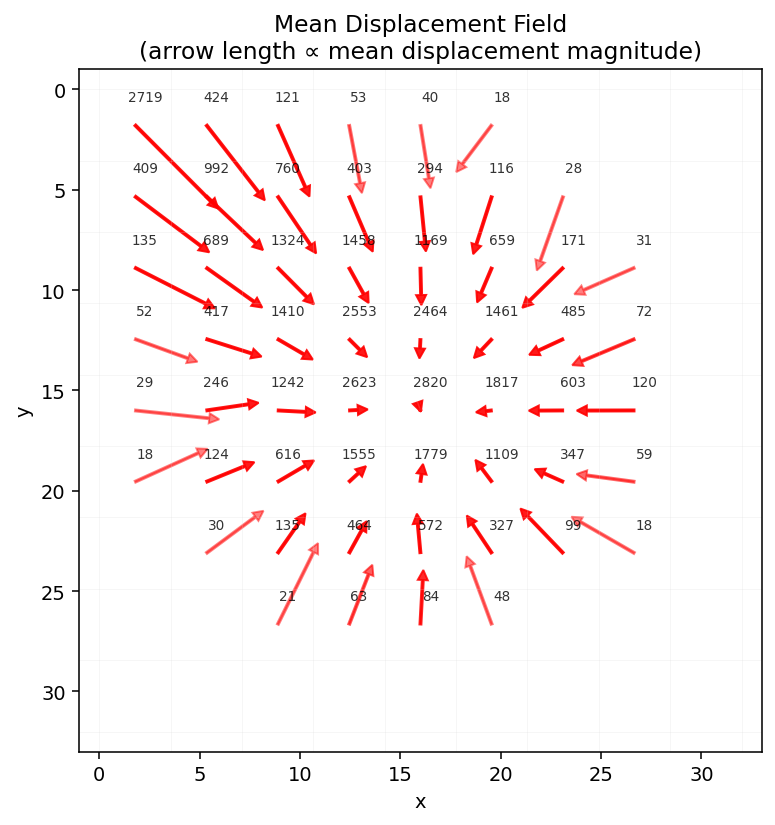

Empirical field from real data:
  Active grid cells: 56/81
  Total displacement samples: 38,000
  Average samples per active cell: 678.6


In [27]:
# Cell 3: Simplified Empirical Field (Mean Displacement Vectors)

def plot_clean_empirical_field(coords, H=32, grid_size=8):
    """Clean field plot - arrow length = mean displacement magnitude at each grid cell."""
    B, T, _ = coords.shape
    grid_step = H / grid_size
    
    # Collect displacements by grid
    field_data = {}
    for b in range(B):
        for t in range(T-1):
            y_curr, x_curr = coords[b, t]
            y_next, x_next = coords[b, t+1]
            
            gy = int(y_curr / grid_step)
            gx = int(x_curr / grid_step)
            gy = max(0, min(grid_size-1, gy))
            gx = max(0, min(grid_size-1, gx))
            
            dy = float(y_next - y_curr)
            dx = float(x_next - x_curr)
            
            key = (gy, gx)
            if key not in field_data:
                field_data[key] = []
            field_data[key].append([dy, dx])
    
    # Compute mean displacements (average, not sum)
    mean_disps = {}
    for key, disps in field_data.items():
        disps_array = np.array(disps)
        mean_disps[key] = {
            'mean': disps_array.mean(axis=0),  # average displacement vector
            'count': len(disps)
        }
    
    # Plot clean field
    fig, ax = plt.subplots(figsize=(6,6), facecolor='white')
    ax.set_facecolor('white')
    
    # Background grid
    for i in range(grid_size + 1):
        x_line = i * grid_step
        y_line = i * grid_step
        ax.axvline(x_line, alpha=0.2, color='lightgray', lw=0.5)
        ax.axhline(y_line, alpha=0.2, color='lightgray', lw=0.5)
    
    # Plot arrows - length = mean displacement magnitude
    for (gy, gx), data in mean_disps.items():
        if data['count'] < 15:  # skip cells with too few samples
            continue
            
        y_pos = (gy + 0.5) * grid_step
        x_pos = (gx + 0.5) * grid_step
        
        dy_mean, dx_mean = data['mean']
        count = data['count']
        
        # Arrow scale for visibility (length represents mean displacement)
        arrow_scale = 1.  # scale up for visibility
        
        # Alpha based on sample reliability
        alpha = min(0.9, count / 100.0)
        alpha = max(0.5, alpha)
        
        # Single color (red), varying alpha
        ax.arrow(x_pos, y_pos, dx_mean*arrow_scale, dy_mean*arrow_scale,
                 head_width=0.5, head_length=0.5,
                 fc='red', ec='red', alpha=alpha,
                 length_includes_head=True, width=0.1)
        
        # Show sample count (smaller font)
        ax.text(x_pos+0.5, y_pos-1.2, f'{count}', 
               fontsize=7, alpha=0.8, ha='center', color='black')
    
    ax.set_xlim(-1, H+1); ax.set_ylim(H+1, -1)
    ax.set_aspect('equal')
    ax.set_title(f'Mean Displacement Field\n(arrow length ∝ mean displacement magnitude)')
    ax.set_xlabel('x'); ax.set_ylabel('y')
    
    plt.tight_layout()
    plt.show()
    
    # Summary stats
    total_samples = sum(data['count'] for data in mean_disps.values())
    active_cells = len([k for k, data in mean_disps.items() if data['count'] >= 15])
    
    print(f"Empirical field from real data:")
    print(f"  Active grid cells: {active_cells}/{grid_size*grid_size}")
    print(f"  Total displacement samples: {total_samples:,}")
    print(f"  Average samples per active cell: {total_samples/active_cells:.1f}")

plot_clean_empirical_field(coords_train, H=32, grid_size=9)

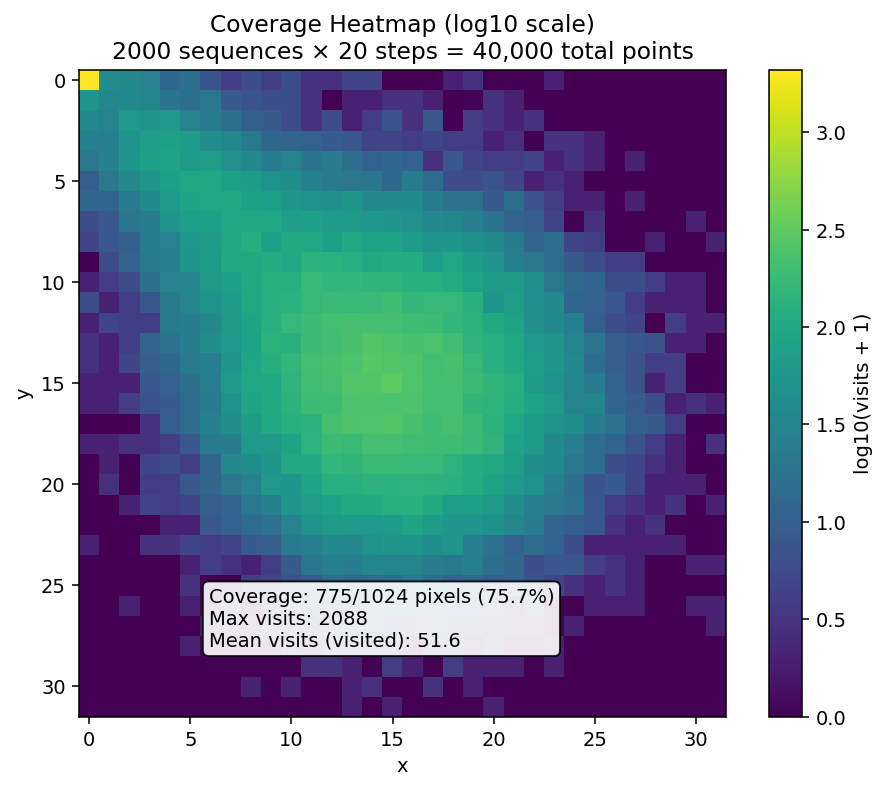

Coverage Statistics:
  Dataset size: 2,000 sequences × 20 steps = 40,000 position samples
  Visited pixels: 775/1024 (0.757)
  Max visits per pixel: 2088
  Mean visits (visited pixels only): 51.61


In [9]:
def plot_coverage_heatmap_log(coords, H=32):
    """Coverage heatmap with log scale, using full 2000 dataset."""
    B, T, _ = coords.shape
    
    coverage = np.zeros((H, H), dtype=np.int32)
    for b in range(B):
        for t in range(T):
            y, x = coords[b, t]
            yi, xi = int(round(float(y))), int(round(float(x)))
            yi = max(0, min(H-1, yi)); xi = max(0, min(H-1, xi))
            coverage[yi, xi] += 1
    
    # Use log scale for better visualization
    log_coverage = np.log10(coverage + 1)  # +1 to avoid log(0)
    
    plt.figure(figsize=(8, 6))
    plt.imshow(log_coverage, origin='upper', cmap='viridis')
    plt.title(f'Coverage Heatmap (log10 scale)\n{B} sequences × {T} steps = {B*T:,} total points')
    
    # Custom colorbar with original values
    cbar = plt.colorbar(label='log10(visits + 1)')
    
    # Add text annotations for key values
    plt.xlabel('x'); plt.ylabel('y')
    
    # Stats
    visited_pixels = np.sum(coverage > 0)
    coverage_ratio = visited_pixels / (H * H)
    max_visits = coverage.max()
    mean_visits = coverage[coverage > 0].mean()
    
    plt.text(0.2, 0.2, f'Coverage: {visited_pixels}/{H*H} pixels ({coverage_ratio:.1%})\n'
                         f'Max visits: {max_visits}\n'
                         f'Mean visits (visited): {mean_visits:.1f}',
             transform=plt.gca().transAxes, fontsize=10,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))
    
    plt.show()
    
    print(f"Coverage Statistics:")
    print(f"  Dataset size: {B:,} sequences × {T} steps = {B*T:,} position samples")
    print(f"  Visited pixels: {visited_pixels}/{H*H} ({coverage_ratio:.3f})")
    print(f"  Max visits per pixel: {max_visits}")
    print(f"  Mean visits (visited pixels only): {mean_visits:.2f}")
    
    return coverage

coverage = plot_coverage_heatmap_log(coords_train)

In [10]:
def motion_statistics_only(coords, name):
    """Motion analysis using full real dataset."""
    B, T, _ = coords.shape
    displacements = coords[:, 1:, :] - coords[:, :-1, :]
    
    dy = displacements[:, :, 0].numpy().flatten()
    dx = displacements[:, :, 1].numpy().flatten()
    angles = np.arctan2(dy, dx)
    speeds = np.sqrt(dy*dy + dx*dx)
    
    plt.figure(figsize=(12, 3))
    
    # Angle histogram
    plt.subplot(1, 3, 1)
    plt.hist(angles, bins=36, density=True, alpha=0.7, color='blue')
    plt.title(f'{name}: Angle Distribution')
    plt.xlabel('angle (rad)'); plt.ylabel('density')
    plt.axvline(0, color='red', linestyle='--', alpha=0.7, label='→')
    plt.axvline(np.pi/2, color='green', linestyle='--', alpha=0.7, label='↓')
    plt.axvline(np.pi/4, color='orange', linestyle='--', alpha=0.7, label='↘')
    plt.legend()
    
    # Speed histogram
    plt.subplot(1, 3, 2)
    plt.hist(speeds, bins=30, density=True, alpha=0.7, color='orange')
    plt.title(f'{name}: Speed Distribution')
    plt.xlabel('displacement magnitude'); plt.ylabel('density')
    
    # Mean displacement per timestep
    plt.subplot(1, 3, 3)
    mean_dy_by_t = displacements[:, :, 0].mean(dim=0).numpy()
    mean_dx_by_t = displacements[:, :, 1].mean(dim=0).numpy()
    timesteps = range(len(mean_dy_by_t))
    
    plt.plot(timesteps, mean_dx_by_t, 'o-', label='mean dx', alpha=0.8)
    plt.plot(timesteps, mean_dy_by_t, 's-', label='mean dy', alpha=0.8)
    plt.title(f'{name}: Mean Displacement by Timestep')
    plt.xlabel('timestep'); plt.ylabel('mean displacement')
    plt.legend(); plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"Motion Statistics ({len(speeds):,} real displacement samples):")
    print(f"  Mean angle: {math.degrees(angles.mean()):.1f}°")
    print(f"  Mean speed: {speeds.mean():.3f} ± {speeds.std():.3f}")
    print(f"  Overall bias: dx={dx.mean():.3f}, dy={dy.mean():.3f}")


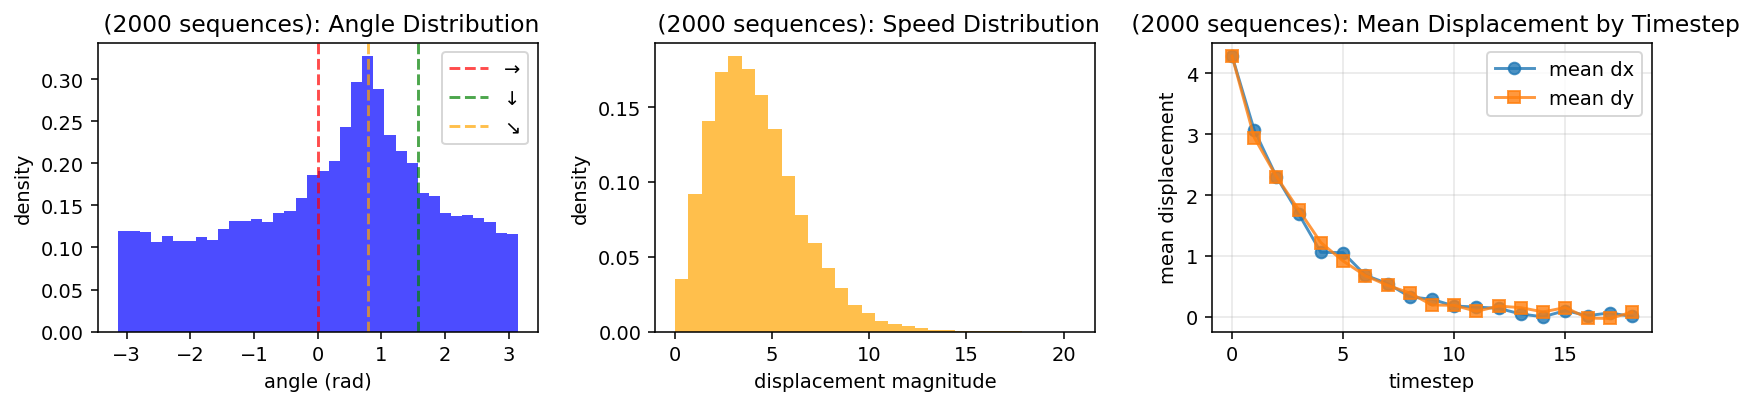

Motion Statistics (38,000 real displacement samples):
  Mean angle: 12.5°
  Mean speed: 4.154 ± 2.304
  Overall bias: dx=0.842, dy=0.845


In [11]:
motion_statistics_only(coords_train, f' (2000 sequences)')

In [12]:
def show_frame_comparison(frames_sparse, frames_gauss, coords, seq_idx=0):
    """Show sparse vs gaussian for one sample sequence."""
    steps = [0, 5, 10, 15, 20, 24]  # sample timesteps
    n = len(steps)
    
    plt.figure(figsize=(2*n, 5))
    
    for i, t in enumerate(steps):
        if t >= frames_sparse.shape[1]:
            continue
            
        # Sparse frame
        plt.subplot(2, n, i+1)
        plt.imshow(frames_sparse[seq_idx, t, 0].numpy(), vmin=0, vmax=1, cmap='gray')
        plt.axis('off')
        plt.title(f'Sparse t={t}', fontsize=10)
        
        # Gaussian frame
        plt.subplot(2, n, n+i+1)
        plt.imshow(frames_gauss[seq_idx, t, 0].numpy(), cmap='hot')
        plt.axis('off')
        plt.title(f'Gaussian t={t}', fontsize=10)
    
    plt.suptitle(f' Frame Representations (sample {seq_idx})', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    # Show coordinates for reference
    print(f"Sample {seq_idx} coordinates at displayed timesteps:")
    for t in steps:
        if t < coords.shape[1]:
            y, x = coords[seq_idx, t]
            print(f"  t={t}: ({y:.2f}, {x:.2f})")


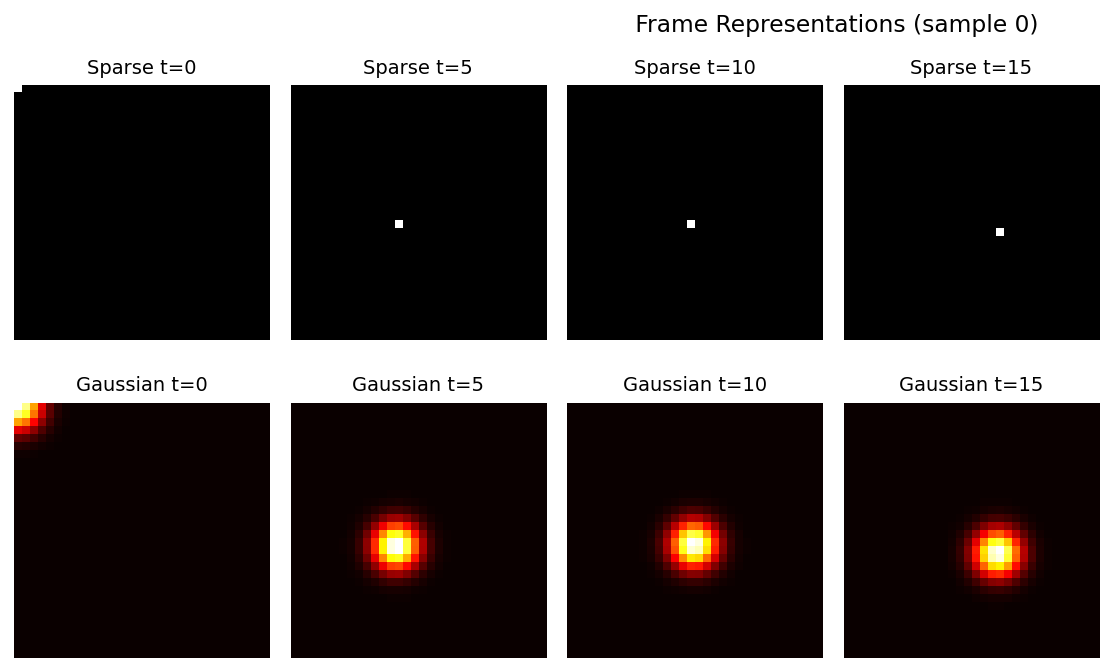

Sample 0 coordinates at displayed timesteps:
  t=0: (0.00, 0.00)
  t=5: (17.49, 12.63)
  t=10: (17.32, 15.36)
  t=15: (18.37, 18.71)


In [13]:

show_frame_comparison(frames_train_sparse, frames_train_gauss, coords_train, 0)

In [14]:
compare_modes_clean()

NameError: name 'compare_modes_clean' is not defined

In [ ]:
def final_analysis():
    """Summary of the generated dataset."""
    B, T = coords_train.shape[:2]
    
    # Overall statistics
    all_y = coords_train[:, :, 0].numpy().flatten()
    all_x = coords_train[:, :, 1].numpy().flatten()
    
    displacements = coords_train[:, 1:, :] - coords_train[:, :-1, :]
    all_speeds = torch.norm(displacements, dim=2).numpy().flatten()
    
    print(f"Generated: {B:,} sequences × {T} steps = {B*T:,} position samples")
    print(f"Configuration: step_scale={CONFIG['step_scale']}")
    print(f"")
    print(f"Spatial coverage:")
    print(f"  y range: [{all_y.min():.1f}, {all_y.max():.1f}]")
    print(f"  x range: [{all_x.min():.1f}, {all_x.max():.1f}]") 
    print(f"  coverage ratio: {(coverage > 0).mean():.3f}")
    print(f"")
    print(f"Motion patterns:")
    print(f"  mean speed: {all_speeds.mean():.3f} ± {all_speeds.std():.3f}")
    print(f"  total displacement samples: {len(all_speeds):,}")
    
    # Boundary behavior
    at_boundary = ((all_y <= 0.1) | (all_y >= 31.9) | (all_x <= 0.1) | (all_x >= 31.9))
    print(f"  boundary contact: {at_boundary.mean():.3f} fraction")


In [ ]:
final_analysis()

Generated: 2,000 sequences × 20 steps = 40,000 position samples
Configuration: step_scale=5.0

Spatial coverage:
  y range: [0.0, 31.0]
  x range: [0.0, 31.0]
  coverage ratio: 0.763

Motion patterns:
  mean speed: 4.118 ± 2.352
  total displacement samples: 38,000
  boundary contact: 0.058 fraction
